## Capstone Project – The Battle of Neighborhoods


### 1. Introduction:
The purpose of this Project is to find better facillities and more economic arround the area of carborough, Toronto. 

Criteria are for ease of accessing to Cafe, School, Super market, medical shops, grocery shops etc.

With this project we aim to create an analysis of features wich are about finding a better neighborhood as a comparative analysis between neighborhoods. The features include median housing price and better school according to ratings, veneus and house prices of that particular area.

### 2. Data Section
Data Link: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

Will use Scarborough dataset which we scrapped from wikipedia on Week 3. 

Foursquare API Data:
In order to get data about different venues in different neighborhoods we will use "Foursquare" locational information. 

After we have gathered the list of neighborhoods, we will connect to the Foursquare API to gather information about venues inside each and every neighborhood. 

The data retrieved from Foursquare contained information of venues within a specified distance of the longitude and latitude of the postcodes. The information obtained per venue as follows:

1. Neighborhood
2. Neighborhood Latitude
3. Neighborhood Longitude
4. Venue
5. Name of the venue e.g. the name of a store or restaurant
6. Venue Latitude
7. Venue Longitude
8. Venue Category



##### Python packages and Dependencies

In [14]:
import json # library to handle JSON files
import xml
import pandas as pd #Python library data manipulation and analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
%matplotlib inline

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
import warnings
warnings.filterwarnings("ignore")
from bs4 import BeautifulSoup
import requests


#####  Import Data

In [15]:
# download url data from internet
#Scrap List of postal codes of Canada wiki page content by using BeautifulSoup

url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
source = requests.get(url).text
Canada_data = BeautifulSoup(source, 'lxml')

In [16]:
# Convert content of PostalCode HTML table as dataframe
# creat a new Dataframe

column_names = ['Postalcode','Borough','Neighborhood']
toronto = pd.DataFrame(columns = column_names)

# loop through to find postcode, borough, neighborhood 
content = Canada_data.find('div', class_='mw-parser-output')
table = content.table.tbody
postcode = 0
borough = 0
neighborhood = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text
            i = i + 1
        elif i == 1:
            borough = td.text
            i = i + 1
        elif i == 2: 
            neighborhood = td.text.strip('\n').replace(']','')
    toronto = toronto.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)

# clean dataframe 
toronto = toronto[toronto.Borough!='Not assigned\n']
toronto = toronto[toronto.Borough!= 0]
toronto.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,toronto.shape[0]):
    if toronto.iloc[i][2] == 'Not assigned\n':
        toronto.iloc[i][2] = toronto.iloc[i][1]
        i = i+1
                                 
df = toronto.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()

,Postalcode,Borough,Neighborhood
0,M1B\n,Scarborough\n,"Malvern, Rouge"
1,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek"
2,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill"
3,M1G\n,Scarborough\n,Woburn
4,M1H\n,Scarborough\n,Cedarbrae


##### Data Cleaning


In [17]:
df = df.dropna()
empty = 'Not assigned\n'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]

In [18]:
df.head()

,Postalcode,Borough,Neighborhood
0,M1B\n,Scarborough\n,"Malvern, Rouge"
1,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek"
2,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill"
3,M1G\n,Scarborough\n,Woburn
4,M1H\n,Scarborough\n,Cedarbrae


In [19]:

def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['Postalcode', 'Borough'])
df2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

In [20]:
print(df2.shape)
df2.head()

(103, 3)


,Postalcode,Borough,Neighborhood
0,M1B\n,Scarborough\n,"Malvern, Rouge"
1,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek"
2,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill"
3,M1G\n,Scarborough\n,Woburn
4,M1H\n,Scarborough\n,Cedarbrae


In [21]:
import geocoder
def get_latlng(postal_code):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lat_lng_coords = g.latlng
    return lat_lng_coords
    
get_latlng('M4G\n')

[43.709020000000066, -79.36348999999996]

In [30]:
#Retrieving Postal Code coordinates

postal_codes = df['Postalcode']    
coords = [ get_latlng(postal_code) for postal_code in postal_codes.tolist() ]

In [31]:
#Adding columns Latitude and Longitude

df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']

In [32]:
df[df.Postalcode == 'M4G\n']

,Postalcode,Borough,Neighborhood,Latitude,Longitude
38,M4G\n,East York\n,Leaside,43.70902,-79.36349


In [33]:
df.head(10)

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B\n,Scarborough\n,"Malvern, Rouge",43.81139,-79.19662
1,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek",43.78574,-79.15875
2,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill",43.76575,-79.17470
3,M1G\n,Scarborough\n,Woburn,43.76812,-79.21761
4,M1H\n,Scarborough\n,Cedarbrae,43.76944,-79.23892
5,M1J\n,Scarborough\n,Scarborough Village,43.74446,-79.23117
6,M1K\n,Scarborough\n,"Kennedy Park, Ionview, East Birchmount Park",43.72582,-79.26461
7,M1L\n,Scarborough\n,"Golden Mile, Clairlea, Oakridge",43.71289,-79.28506
8,M1M\n,Scarborough\n,"Cliffside, Cliffcrest, Scarborough Village West",43.72360,-79.23496
9,M1N\n,Scarborough\n,"Birch Cliff, Cliffside West",43.69510,-79.26466


In [35]:
# create map of Toronto using latitude and longitude values
map_Scarborough = folium.Map(location=[43.773077, -79.257774], zoom_start=10)

# add markers to map
for lat, lng, nei in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Scarborough)  
    
map_Scarborough

In [159]:
# @hiddel_cell
CLIENT_ID = 'ZRZJHANO0DXVX4QR2PHAPHC5SG2ZQ3E43Y0VOZFVT3E1ISTE' # your Foursquare ID
CLIENT_SECRET = 'WXSERBM1Q14B5FHNY4P1OGGHNWWHIO0QNHQZOTOER4QXZQFH' # your Foursquare Secret
VERSION = '20210115' # Foursquare API version

In [160]:
 # 43.773077, -79.257774.
radius = 500 
LIMIT = 50
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    #latitude_n1, 
   #longitude_n1, 
43.773077,
-79.257774,
    radius, 
   LIMIT)
results = requests.get(url).json()

In [161]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups',
       'venue.location.neighborhood', 'venue.venuePage.id'],
      dtype='object')

In [162]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Nearby Venues


In [163]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Disney Store,"[{'id': '4bf58dd8d48988d1f3941735', 'name': 'T...",43.775537,-79.256833
1,SEPHORA,"[{'id': '4bf58dd8d48988d10c951735', 'name': 'C...",43.775017,-79.258109
2,Tommy Hilfiger,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776015,-79.257369
3,Coliseum Scarborough Cinemas,"[{'id': '4bf58dd8d48988d17f941735', 'name': 'M...",43.775995,-79.255649
4,American Eagle Store,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776012,-79.258334


##  5. Categories of Nearby Venues/Locations

In [164]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(10)

,name,categories,lat,lng
0,Disney Store,Toy / Game Store,43.775537,-79.256833
1,SEPHORA,Cosmetics Shop,43.775017,-79.258109
2,Tommy Hilfiger,Clothing Store,43.776015,-79.257369
3,Coliseum Scarborough Cinemas,Movie Theater,43.775995,-79.255649
4,American Eagle Store,Clothing Store,43.776012,-79.258334
5,Hot Topic,Clothing Store,43.775450,-79.257929
6,Chipotle Mexican Grill,Mexican Restaurant,43.776410,-79.258069
7,Shoppers Drug Mart,Pharmacy,43.773305,-79.251662
8,St. Andrews Fish & Chips,Fish & Chips Shop,43.771865,-79.252645
9,Tim Hortons,Coffee Shop,43.769936,-79.260368


In [62]:

# Top 10 Categories
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Clothing Store        7
Coffee Shop           3
Pharmacy              2
Department Store      2
Sandwich Place        2
Restaurant            2
Bank                  1
Food Court            1
Gift Shop             1
Mexican Restaurant    1
Name: categories, dtype: int64

In [63]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [56]:
# Nearby Venues
Scarborough_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

In [64]:
print(Scarborough_venues.shape)

(3574, 7)


In [76]:
print('There are {} Uniques Categories.'.format(len(Scarborough_venues['Venue Category'].unique())))
Scarborough_venues.groupby('Neighborhood').count().head()

There are 303 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,23,23,23,23,23,23
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",13,13,13,13,13,13
Bayview Village,6,6,6,6,6,6
"Bedford Park, Lawrence Manor East",27,27,27,27,27,27


In [77]:
# one hot encoding
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Scarborough_onehot['Neighborhood'] = Scarborough_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]
Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_onehot.head(5)

,Zoo Exhibit,Accessories Store,Adult Boutique,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Newsagent,Nightclub,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pie Shop,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Street Art,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / A

In [177]:
num_top_venues = 5
for hood in Scarborough_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp =Scarborough_grouped[Scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
            venue  freq
0   Shopping Mall  0.09
1      Print Shop  0.04
2  Sandwich Place  0.04
3  Clothing Store  0.04
4     Coffee Shop  0.04


----Alderwood, Long Branch----
         venue  freq
0          Pub  0.12
1  Gas Station  0.12
2     Pharmacy  0.12
3  Pizza Place  0.12
4  Coffee Shop  0.12


----Bathurst Manor, Wilson Heights, Downsview North----
                      venue  freq
0               Coffee Shop  0.15
1               Pizza Place  0.15
2          Sushi Restaurant  0.08
3       Fried Chicken Joint  0.08
4  Mediterranean Restaurant  0.08


----Bayview Village----
              venue  freq
0              Park  0.17
1  Asian Restaurant  0.17
2       Flower Shop  0.17
3             Trail  0.17
4       Gas Station  0.17


----Bedford Park, Lawrence Manor East----
                venue  freq
0         Coffee Shop  0.07
1         Pizza Place  0.07
2      Sandwich Place  0.07
3  Italian Restaurant  0.07
4     Thai Restaurant  0.07


----Berczy Park----
 

In [178]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Most Common venues near neighborhood

In [224]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Scarborough_grouped['Neighborhood']

for ind in np.arange(Scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()
                                

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Shopping Mall,Pizza Place,Latin American Restaurant,Chinese Restaurant,Supermarket,Newsagent,Bank,Bakery,Badminton Court,Clothing Store
1,"Alderwood, Long Branch",Pub,Dance Studio,Gas Station,Gym,Pharmacy,Pizza Place,Coffee Shop,Print Shop,Farm,Farmers Market
2,"Bathurst Manor, Wilson Heights, Downsview North",Pizza Place,Coffee Shop,Sushi Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Restaurant,Deli / Bodega,Park,Sandwich Place,Intersection
3,Bayview Village,Dog Run,Asian Restaurant,Gas Station,Park,Trail,Flower Shop,Curling Ice,Farm,Eastern European Restaurant,Electronics Store
4,"Bedford Park, Lawrence Manor East",Pizza Place,Sandwich Place,Italian Restaurant,Coffee Shop,Thai Restaurant,Comfort Food Restaurant,Sports Club,Butcher,Café,Restaurant


In [227]:
neighborhoods_venues_sorted.to_csv(r'C:\Users\amanta\Documents\neighb.csv',index = False, header=True)


## 3. Methodology Section
#### k-means Clustering

In [180]:
# set number of clusters
# Using k-means to cluster the neighborhood into 3 clusters.

Scarborough_grouped_clustering = Scarborough_grouped.drop('Neighborhood', 1)
#Scarborough_grouped_clustering = Scarborough_grouped

# run k-means clustering
kmeans = KMeans(n_clusters=3, random_state=0).fit(Scarborough_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 2])

In [181]:
Scarborough_merged =df.iloc[:98,:]

# add clustering labels
Scarborough_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Scarborough_merged = Scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Scarborough_merged.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B\n,Scarborough\n,"Malvern, Rouge",43.81139,-79.19662,1,Zoo Exhibit,Fast Food Restaurant,Farm,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market
1,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek",43.78574,-79.15875,1,Bar,Fish & Chips Shop,Yoga Studio,Farm,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant
2,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill",43.76575,-79.17470,1,Park,Gym / Fitness Center,Gymnastics Gym,Athletics & Sports,Yoga Studio,Ethiopian Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant
3,M1G\n,Scarborough\n,Woburn,43.76812,-79.21761,1,Park,Fast Food Restaurant,Chinese Restaurant,Coffee Shop,Fish & Chips Shop,Filipino Restaurant,Field,Fish Market,Farmers Market,Farm
4,M1H\n,Scarborough\n,Cedarbrae,43.76944,-79.23892,1,Bakery,Thai Restaurant,Caribbean Restaurant,Athletics & Sports,Hakka Restaurant,Gas Station,Bank,Field,Fast Food Restaurant,Farmers Market


## 4. Results Section

#### Map of Clusters

In [182]:
kclusters = 10
map_clusters = folium.Map(location=[43.773077, -79.257774], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map
markers_colors = []
for lat, lon, nei , cluster in zip(Scarborough_merged['Latitude'], 
                                   Scarborough_merged['Longitude'], 
                                   Scarborough_merged['Neighborhood'], 
                                   Scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [87]:
df1=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 0,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]

df2=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 1,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df3=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 2,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]

#### Average Housing Prices

In [183]:

Scarborough_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0]})

<AxesSubplot:xlabel='Neighborhood'>

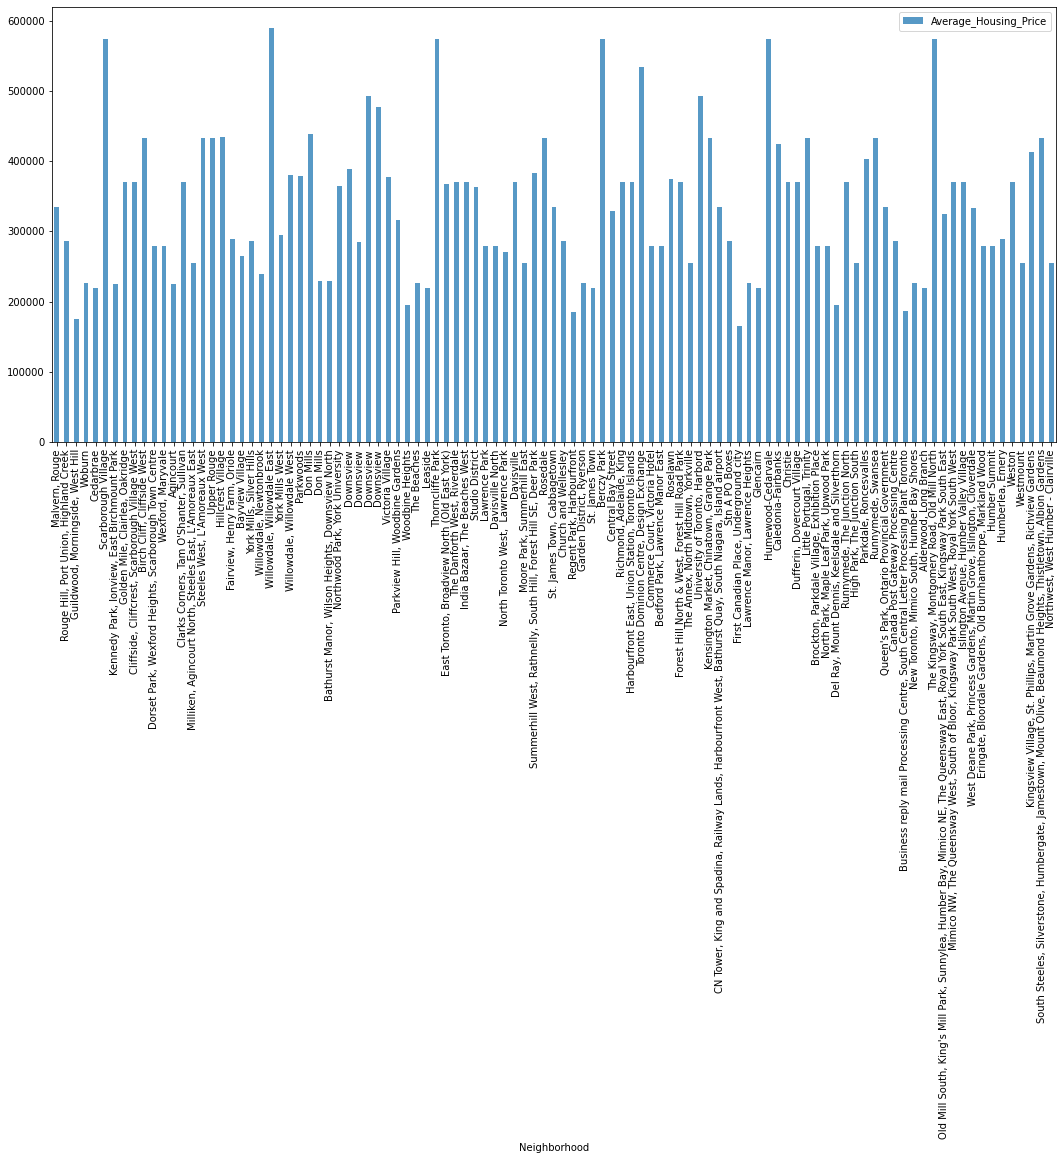

In [109]:
Scarborough_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)
Scarborough_Avg_HousingPrice.plot(kind='bar',figsize=(18,8),alpha=0.75)

#### School Rating by Clusters

In [184]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster3":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

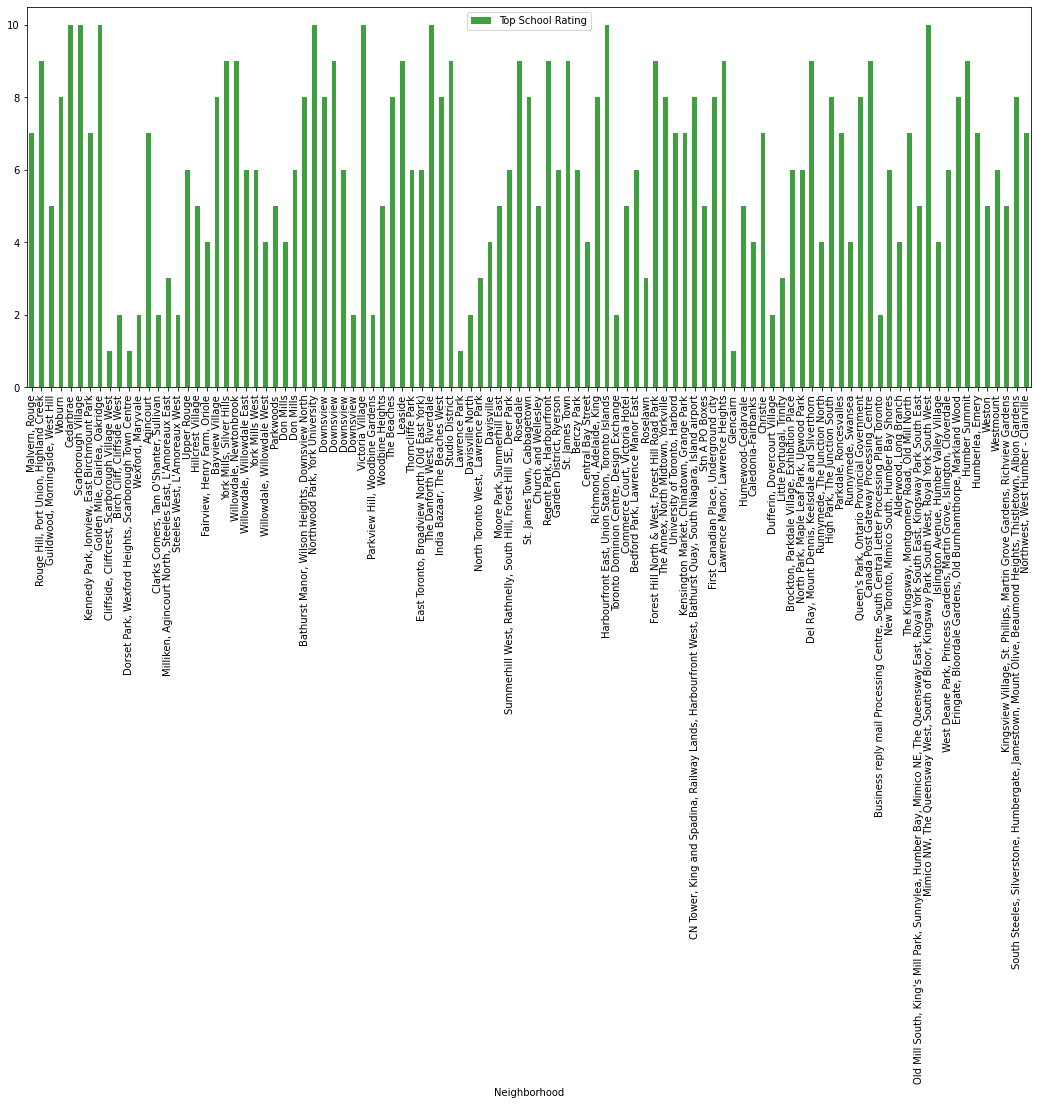

In [114]:
Scarborough_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

Scarborough_school_ratings.plot(kind='bar',figsize=(18,7),color='green',alpha=0.75);

#### Filtering neighborhoods to meet our most wanted venues

In [241]:
#df.drop(df.columns[[1, 2]], axis=1, inplace=True)
#neighborhoods_venues_sorted.drop(neighborhoods_venues_sorted.columns[[4]], axis=1, inplace=True)
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Agincourt,Shopping Mall,Pizza Place,Latin American Restaurant
1,"Alderwood, Long Branch",Pub,Dance Studio,Gas Station
2,"Bathurst Manor, Wilson Heights, Downsview North",Pizza Place,Coffee Shop,Sushi Restaurant
3,Bayview Village,Dog Run,Asian Restaurant,Gas Station
4,"Bedford Park, Lawrence Manor East",Pizza Place,Sandwich Place,Italian Restaurant


In [244]:
#dfCo2group = neighborhoods_venues_sorted['Neighborhood','1st Most Common Venue','2nd Most Common Venue',]
dfCo2group = neighborhoods_venues_sorted.groupby(['1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','Neighborhood']).count()
dfCo2group.reset_index(inplace=True)
dfCo2group.head()


,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Neighborhood
0,Bakery,Park,Light Rail Station,"Dorset Park, Wexford Heights, Scarborough Town..."
1,Bakery,Thai Restaurant,Caribbean Restaurant,Cedarbrae
2,Bank,Burger Joint,Mediterranean Restaurant,"Forest Hill North & West, Forest Hill Road Park"
3,Bar,Convenience Store,Thai Restaurant,"High Park, The Junction South"
4,Bar,Fish & Chips Shop,Yoga Studio,"Rouge Hill, Port Union, Highland Creek"


In [254]:
dfCo2group.to_csv(r'C:\Users\amanta\Documents\dfCo2group.csv',index = False, header=True)
dfCo2group.head()



,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Neighborhood
0,Bakery,Park,Light Rail Station,"Dorset Park, Wexford Heights, Scarborough Town..."
1,Bakery,Thai Restaurant,Caribbean Restaurant,Cedarbrae
2,Bank,Burger Joint,Mediterranean Restaurant,"Forest Hill North & West, Forest Hill Road Park"
3,Bar,Convenience Store,Thai Restaurant,"High Park, The Junction South"
4,Bar,Fish & Chips Shop,Yoga Studio,"Rouge Hill, Port Union, Highland Creek"


In [255]:
dfCo2groupdf = pd.read_csv(r"C:\Users\amanta\Documents\dfCo2group.csv")

dfCo2groupdf.head()


,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Neighborhood
0,Bakery,Park,Light Rail Station,"Dorset Park, Wexford Heights, Scarborough Town..."
1,Bakery,Thai Restaurant,Caribbean Restaurant,Cedarbrae
2,Bank,Burger Joint,Mediterranean Restaurant,"Forest Hill North & West, Forest Hill Road Park"
3,Bar,Convenience Store,Thai Restaurant,"High Park, The Junction South"
4,Bar,Fish & Chips Shop,Yoga Studio,"Rouge Hill, Port Union, Highland Creek"


In [273]:
#select Neighborhood by venue
filter1=dfCo2groupdf["1st Most Common Venue"].isin(["Park", "Bakery","Bookstore","Gym","Grocery Store"])
dfCo2groupdf[filter1] 

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Neighborhood
0,Bakery,Park,Light Rail Station,"Dorset Park, Wexford Heights, Scarborough Town..."
1,Bakery,Thai Restaurant,Caribbean Restaurant,Cedarbrae
53,Grocery Store,Pharmacy,Hardware Store,"South Steeles, Silverstone, Humbergate, Jamest..."
54,Grocery Store,Pizza Place,Photography Lab,Glencairn
67,Park,Bakery,Pharmacy,Hillcrest Village
68,Park,Bookstore,Restaurant,Lawrence Park
69,Park,Doner Restaurant,Dry Cleaner,"York Mills, Silver Hills"
70,Park,Fast Food Restaurant,Chinese Restaurant,Woburn
71,Park,Food & Drink Shop,Construction & Landscaping,Parkwoods
72,Park,Grocery Store,Candy Store,Rosedale


## 5. Discussion Section
Problem Which Tried to Solve:
The major purpose of this project, is to suggest a better neighborhood in orde people have the change to look for a better place to move

## 6. Conclusion Section
We can use the results for deeper analysis in order to move or improve our neighborhoods.

